In [443]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pickle
import os
import yfinance as yf
import pandas_datareader as pdr

In [445]:
yf.pdr_override()
sp500 = pdr.get_data_yahoo('SPY', start='2011-01-03', end='2020-12-31')
sp500

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,127.599998,125.699997,126.709999,127.050003,138725200.0,101.573624
2011-01-04,127.370003,126.190002,127.330002,126.980003,137409700.0,101.517670
2011-01-05,127.720001,126.459999,126.580002,127.639999,133975300.0,102.045288
2011-01-06,127.830002,127.010002,127.690002,127.389999,122519000.0,101.845421
2011-01-07,127.769997,126.150002,127.559998,127.139999,156034600.0,101.645538
...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,26457900.0,359.978088
2020-12-28,372.589996,371.070007,371.739990,372.170013,39000400.0,363.070648
2020-12-29,374.000000,370.829987,373.809998,371.459991,53680500.0,362.377930


In [451]:
sp500_train = sp500.loc[:'2016-01-01']
sp500_test = sp500.loc['2016-01-01':]

In [452]:
sp500_train['return'] = np.log(sp500_train.Close/sp500_train.Close.shift(1))
sp500_train['cumreturn'] = sp500_train['return'].cumsum().apply(np.exp)
sp500_train

<ipython-input-452-e3d94f24eb4c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_train['return'] = np.log(sp500_train.Close/sp500_train.Close.shift(1))
<ipython-input-452-e3d94f24eb4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_train['cumreturn'] = sp500_train['return'].cumsum().apply(np.exp)


,High,Low,Open,Close,Volume,Adj Close,return,cumreturn
Date,,,,,,,,
2011-01-03,127.599998,125.699997,126.709999,127.050003,138725200.0,101.573624,NaN,NaN
2011-01-04,127.370003,126.190002,127.330002,126.980003,137409700.0,101.517670,-0.000551,0.999449
2011-01-05,127.720001,126.459999,126.580002,127.639999,133975300.0,102.045288,0.005184,1.004644
2011-01-06,127.830002,127.010002,127.690002,127.389999,122519000.0,101.845421,-0.001961,1.002676
2011-01-07,127.769997,126.150002,127.559998,127.139999,156034600.0,101.645538,-0.001964,1.000708
...,...,...,...,...,...,...,...,...
2015-12-24,206.330002,205.419998,205.720001,205.679993,48539600.0,182.178772,-0.001652,1.618890
2015-12-28,205.259995,203.940002,204.860001,205.210007,65899900.0,181.762512,-0.002288,1.615191
2015-12-29,207.789993,206.470001,206.509995,207.399994,92640700.0,183.702301,0.010615,1.632428


In [453]:
sp500_test['return'] = np.log(sp500_test.Close/sp500_test.Close.shift(1))
sp500_test['cumreturn'] = sp500_test['return'].cumsum().apply(np.exp)
sp500_test

<ipython-input-453-ecbb24bcf999>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['return'] = np.log(sp500_test.Close/sp500_test.Close.shift(1))
<ipython-input-453-ecbb24bcf999>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['cumreturn'] = sp500_test['return'].cumsum().apply(np.exp)


,High,Low,Open,Close,Volume,Adj Close,return,cumreturn
Date,,,,,,,,
2016-01-04,201.029999,198.589996,200.490005,201.020004,222353500.0,178.051285,NaN,NaN
2016-01-05,201.899994,200.050003,201.399994,201.360001,110845800.0,178.352448,0.001690,1.001691
2016-01-06,200.059998,197.600006,198.339996,198.820007,152112600.0,176.102646,-0.012694,0.989056
2016-01-07,197.440002,193.589996,195.330002,194.050003,213436100.0,171.877655,-0.024284,0.965327
2016-01-08,195.850006,191.580002,195.190002,191.919998,209817200.0,169.991058,-0.011037,0.954731
...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,26457900.0,359.978088,0.003883,1.835638
2020-12-28,372.589996,371.070007,371.739990,372.170013,39000400.0,363.070648,0.008554,1.851408
2020-12-29,374.000000,370.829987,373.809998,371.459991,53680500.0,362.377930,-0.001910,1.847876


In [2]:
df = pd.read_csv(f"{os.path.dirname(os.getcwd())}\SP500 stock TI.csv", header=0, index_col=0, parse_dates=[0])
data = df.copy()
data

,Open,High,Low,Close,Adj Close,Volume,symbol,industry,SMA_fast,SMA_slow,...,avg_slow_down,RS_fast,RS_slow,RSI_fast,RSI_slow,RSI_ratio,fast_Ewm,slow_Ewm,MACD,RC
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03 00:00:00-05:00,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29.957083,29.957083,0.000000,NaN
2011-01-04 00:00:00-05:00,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29.864093,29.922211,-0.058119,NaN
2011-01-05 00:00:00-05:00,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29.780639,29.883652,-0.103012,NaN
2011-01-06 00:00:00-05:00,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29.744079,29.857065,-0.112986,NaN
2011-01-07 00:00:00-05:00,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,29.738198,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29.753087,29.846320,-0.093233,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23 00:00:00-05:00,222.630005,224.910004,222.610001,224.240005,224.240005,4983900.0,BRK-B,Financials,223.544000,225.860669,...,0.922000,1.814686,0.553146,64.472056,35.614550,1.810273,223.563879,224.989694,-1.425815,-0.026821
2020-12-24 00:00:00-05:00,224.600006,227.130005,224.210007,226.529999,226.529999,2387000.0,BRK-B,Financials,223.914001,225.561335,...,0.922000,1.646855,0.675343,62.219315,40.310734,1.543492,224.552585,225.182232,-0.629646,-0.019436
2020-12-28 00:00:00-05:00,228.089996,230.149994,227.360001,228.410004,228.410004,3505500.0,BRK-B,Financials,224.910004,225.365335,...,0.922000,4.093173,0.787419,80.365875,44.053393,1.824283,225.838391,225.585703,0.252688,-0.012708


In [273]:
target_df_list = []
for ticker in data.symbol.unique():
    temp = data[data.symbol==ticker]
    temp['Close_Shifted'] = temp['Close'].shift(-6)
    temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
    temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
    temp['return'] = np.log(temp.Close/temp.Close.shift(1))
    target_df_list.append(temp[['Close_Shifted', 'Target', 'Target_Direction', 'return']])
target_df = pd.concat(target_df_list)
target_df

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['return'] = np.log(temp.Close/temp.Close.shift(1))
<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['return'] = np.log(temp.Close/temp.Close.shift(1))
<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['return'] = np.log(temp.Close/temp.Close.shift(1))
<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['return'] = np.log(temp.Close/temp.Close.shift(1))
<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['return'] = np.log(temp.Close/temp.Close.shift(1))
<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target_Direction'] = np.where(temp.Target > 0, 1, 0)
<ipython-input-273-c119794b9c5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

<ipython-input-273-c119794b9c5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Close_Shifted'] = temp['Close'].shift(-6)
<ipython-input-273-c119794b9c5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Target'] = ((temp.Close_Shifted-temp.Open)/(temp.Open)*100).shift(-1)
<ipython-input-273-c119794b9c5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,Close_Shifted,Target,Target_Direction,return
Date,,,,
2011-01-03 00:00:00-05:00,30.715307,2.714932,1,NaN
2011-01-04 00:00:00-05:00,30.851215,4.144447,1,-0.009356
2011-01-05 00:00:00-05:00,30.736767,4.568525,1,-0.002172
2011-01-06 00:00:00-05:00,30.944206,6.815986,1,0.001931
2011-01-07 00:00:00-05:00,31.723890,2.463168,1,0.003369
...,...,...,...,...
2020-12-23 00:00:00-05:00,NaN,NaN,0,0.010580
2020-12-24 00:00:00-05:00,NaN,NaN,0,0.010160
2020-12-28 00:00:00-05:00,NaN,NaN,0,0.008265


In [390]:
data[['Close_Shifted', 'Target', 'Target_Direction', 'return']] = target_df[['Close_Shifted', 'Target', 'Target_Direction', 'return']]
data

,Open,High,Low,Close,Adj Close,Volume,symbol,industry,SMA_fast,SMA_slow,...,fast_Ewm,slow_Ewm,MACD,RC,Close_Shifted,Target,Target_Direction,return,aggregate,agg_scaled
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03 00:00:00-05:00,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,NaN,NaN,...,29.957083,29.957083,0.000000,0.086345,30.715307,2.714932,1,NaN,NaN,NaN
2011-01-04 00:00:00-05:00,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,NaN,NaN,...,29.864093,29.922211,-0.058119,0.086345,30.851215,4.144447,1,-0.009356,0.175493,0.089747
2011-01-05 00:00:00-05:00,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,NaN,NaN,...,29.780639,29.883652,-0.103012,0.086345,30.736767,4.568525,1,-0.002172,-0.956084,0.079168
2011-01-06 00:00:00-05:00,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,NaN,NaN,...,29.744079,29.857065,-0.112986,0.086345,30.944206,6.815986,1,0.001931,0.764276,0.095252
2011-01-07 00:00:00-05:00,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,29.738198,NaN,...,29.753087,29.846320,-0.093233,0.086345,31.723890,2.463168,1,0.003369,0.741151,0.095036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23 00:00:00-05:00,222.630005,224.910004,222.610001,224.240005,224.240005,4983900.0,BRK-B,Financials,223.544000,225.860669,...,223.563879,224.989694,-1.219148,-0.026821,NaN,NaN,0,0.010580,1.146913,0.098829
2020-12-24 00:00:00-05:00,224.600006,227.130005,224.210007,226.529999,226.529999,2387000.0,BRK-B,Financials,223.914001,225.561335,...,224.552585,225.182232,-0.629646,-0.019436,NaN,NaN,0,0.010160,0.382184,0.091680
2020-12-28 00:00:00-05:00,228.089996,230.149994,227.360001,228.410004,228.410004,3505500.0,BRK-B,Financials,224.910004,225.365335,...,225.838391,225.585703,0.252688,-0.012708,NaN,NaN,0,0.008265,-0.058044,0.087564


In [393]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'symbol',
       'industry', 'SMA_fast', 'SMA_slow', 'SMA_ratio', 'SMA_fast_volume',
       'SMA_slow_volume', 'SMA_volume_ratio', 'prev_close', 'TR', 'ATR_fast',
       'ATR_slow', 'ATR_ratio', 'prev_high', 'prev_low', '+DM', '-DM',
       '+DM_fast', '-DM_fast', '+DM_slow', '-DM_slow', '+DI_fast', '-DI_fast',
       '+DI_slow', '-DI_slow', 'DX_fast', 'DX_slow', 'ADX_fast', 'ADX_slow',
       'Lowest_fast', 'High_fast', 'Lowest_slow', 'High_slow',
       'Stochastic_fast', 'Stochastic_slow', 'Stochastic_%D_fast',
       'Stochastic_%D_slow', 'Stochastic_Ratio', 'Diff', 'Up', 'Down',
       'avg_fast_up', 'avg_fast_down', 'avg_slow_up', 'avg_slow_down',
       'RS_fast', 'RS_slow', 'RSI_fast', 'RSI_slow', 'RSI_ratio', 'fast_Ewm',
       'slow_Ewm', 'MACD', 'RC', 'Close_Shifted', 'Target', 'Target_Direction',
       'return', 'aggregate', 'agg_scaled'],
      dtype='object')

In [394]:
# Winsorize indicators
indicators = ['SMA_ratio','SMA_volume_ratio','ATR_ratio','ADX_fast','ADX_slow','Stochastic_Ratio','RSI_ratio','MACD','RC']
for var in indicators:
    data.loc[:,var] = mstats.winsorize(data.loc[:,var], limits = [0.1,0.1])
data

,Open,High,Low,Close,Adj Close,Volume,symbol,industry,SMA_fast,SMA_slow,...,fast_Ewm,slow_Ewm,MACD,RC,Close_Shifted,Target,Target_Direction,return,aggregate,agg_scaled
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03 00:00:00-05:00,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,NaN,NaN,...,29.957083,29.957083,0.000000,0.086345,30.715307,2.714932,1,NaN,NaN,NaN
2011-01-04 00:00:00-05:00,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,NaN,NaN,...,29.864093,29.922211,-0.058119,0.086345,30.851215,4.144447,1,-0.009356,0.175493,0.089747
2011-01-05 00:00:00-05:00,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,NaN,NaN,...,29.780639,29.883652,-0.103012,0.086345,30.736767,4.568525,1,-0.002172,-0.956084,0.079168
2011-01-06 00:00:00-05:00,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,NaN,NaN,...,29.744079,29.857065,-0.112986,0.086345,30.944206,6.815986,1,0.001931,0.764276,0.095252
2011-01-07 00:00:00-05:00,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,29.738198,NaN,...,29.753087,29.846320,-0.093233,0.086345,31.723890,2.463168,1,0.003369,0.741151,0.095036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23 00:00:00-05:00,222.630005,224.910004,222.610001,224.240005,224.240005,4983900.0,BRK-B,Financials,223.544000,225.860669,...,223.563879,224.989694,-1.219148,-0.026821,NaN,NaN,0,0.010580,1.146913,0.098829
2020-12-24 00:00:00-05:00,224.600006,227.130005,224.210007,226.529999,226.529999,2387000.0,BRK-B,Financials,223.914001,225.561335,...,224.552585,225.182232,-0.629646,-0.019436,NaN,NaN,0,0.010160,0.382184,0.091680
2020-12-28 00:00:00-05:00,228.089996,230.149994,227.360001,228.410004,228.410004,3505500.0,BRK-B,Financials,224.910004,225.365335,...,225.838391,225.585703,0.252688,-0.012708,NaN,NaN,0,0.008265,-0.058044,0.087564


In [395]:
# Equal weights to features
data['aggregate'] = data.SMA_ratio * data.SMA_volume_ratio * data.ATR_ratio * data.ADX_fast * data.ADX_slow * \
                    data.Stochastic_Ratio * data.RSI_ratio * data.MACD * data.RC * data['return']
scaler = MinMaxScaler(feature_range=(-1,1))
data['agg_scaled'] = scaler.fit_transform(np.array(data['aggregate']).reshape(-1,1))
data

,Open,High,Low,Close,Adj Close,Volume,symbol,industry,SMA_fast,SMA_slow,...,fast_Ewm,slow_Ewm,MACD,RC,Close_Shifted,Target,Target_Direction,return,aggregate,agg_scaled
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03 00:00:00-05:00,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,NaN,NaN,...,29.957083,29.957083,0.000000,0.086345,30.715307,2.714932,1,NaN,NaN,NaN
2011-01-04 00:00:00-05:00,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,NaN,NaN,...,29.864093,29.922211,-0.058119,0.086345,30.851215,4.144447,1,-0.009356,0.549272,-0.092504
2011-01-05 00:00:00-05:00,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,NaN,NaN,...,29.780639,29.883652,-0.103012,0.086345,30.736767,4.568525,1,-0.002172,0.225968,-0.093309
2011-01-06 00:00:00-05:00,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,NaN,NaN,...,29.744079,29.857065,-0.112986,0.086345,30.944206,6.815986,1,0.001931,-0.220337,-0.094421
2011-01-07 00:00:00-05:00,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,29.738198,NaN,...,29.753087,29.846320,-0.093233,0.086345,31.723890,2.463168,1,0.003369,-0.317328,-0.094662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23 00:00:00-05:00,222.630005,224.910004,222.610001,224.240005,224.240005,4983900.0,BRK-B,Financials,223.544000,225.860669,...,223.563879,224.989694,-1.219148,-0.026821,NaN,NaN,0,0.010580,1.146913,-0.091015
2020-12-24 00:00:00-05:00,224.600006,227.130005,224.210007,226.529999,226.529999,2387000.0,BRK-B,Financials,223.914001,225.561335,...,224.552585,225.182232,-0.629646,-0.019436,NaN,NaN,0,0.010160,0.382184,-0.092920
2020-12-28 00:00:00-05:00,228.089996,230.149994,227.360001,228.410004,228.410004,3505500.0,BRK-B,Financials,224.910004,225.365335,...,225.838391,225.585703,0.252688,-0.012708,NaN,NaN,0,0.008265,-0.058044,-0.094016


In [396]:
ti_cluster_df = data[['symbol', 'agg_scaled']].copy()
ti_cluster_df['Date'] = ti_cluster_df.index.copy()

# Pivot df such that index is Date, column is ticker, cell is returns
ti_wide = ti_cluster_df.pivot(index='Date', columns='symbol', values='agg_scaled')
ti_wide

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04 00:00:00-05:00,-0.092504,-0.093827,-0.006636,-0.093704,NaN,-0.091654,-0.093872,-0.092812,-0.092763,-0.093064,...,-0.039127,-0.093650,-0.093012,-0.091588,NaN,-0.089521,-0.088905,-0.092085,-0.090342,NaN
2011-01-05 00:00:00-05:00,-0.093309,-0.083821,-0.097202,-0.093054,NaN,-0.094396,-0.091075,-0.093872,-0.093924,-0.081618,...,-0.048909,-0.093916,-0.094348,-0.095217,NaN,-0.095528,-0.094279,-0.093542,-0.095326,NaN
2011-01-06 00:00:00-05:00,-0.094421,-0.088444,0.008724,-0.093978,NaN,-0.090725,-0.093481,-0.094240,-0.094610,-0.092621,...,-0.062139,-0.093847,-0.091188,-0.092700,NaN,-0.095582,-0.047033,-0.089294,-0.093002,NaN
2011-01-07 00:00:00-05:00,-0.094662,-0.085124,-0.174734,-0.092530,NaN,-0.092915,-0.096255,-0.092949,-0.094063,-0.099611,...,0.058112,-0.093337,-0.089755,-0.092639,NaN,-0.093183,-0.093495,-0.095743,-0.089007,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24 00:00:00-05:00,-0.093871,-0.093889,-0.093438,-0.091946,-0.093873,-0.094161,-0.095427,-0.093866,-0.093892,-0.093516,...,-0.094778,-0.093752,-0.093875,-0.093868,-0.093697,-0.093810,-0.093853,-0.094131,-0.094021,-0.093869
2020-12-28 00:00:00-05:00,-0.093847,-0.093846,-0.094104,-0.077879,-0.093823,-0.094073,-0.076881,-0.093872,-0.093710,-0.093933,...,-0.093513,-0.093825,-0.093872,-0.093819,-0.093854,-0.093340,-0.093871,-0.093308,-0.093890,-0.093835
2020-12-29 00:00:00-05:00,-0.093899,-0.093933,-0.093898,-0.100287,-0.093828,-0.093688,-0.079735,-0.093869,-0.094028,-0.093624,...,-0.094594,-0.093846,-0.093869,-0.094085,-0.093901,-0.093998,-0.092835,-0.094147,-0.093817,-0.093806


In [397]:
# Transpose df such that index is ticker, column is Date 
# Clusters takes place on index level
ti_wideT = ti_wide.transpose().fillna(0)
ti_wideT

Date,2011-01-03 00:00:00-05:00,2011-01-04 00:00:00-05:00,2011-01-05 00:00:00-05:00,2011-01-06 00:00:00-05:00,2011-01-07 00:00:00-05:00,2011-01-10 00:00:00-05:00,2011-01-11 00:00:00-05:00,2011-01-12 00:00:00-05:00,2011-01-13 00:00:00-05:00,2011-01-14 00:00:00-05:00,...,2020-12-17 00:00:00-05:00,2020-12-18 00:00:00-05:00,2020-12-21 00:00:00-05:00,2020-12-22 00:00:00-05:00,2020-12-23 00:00:00-05:00,2020-12-24 00:00:00-05:00,2020-12-28 00:00:00-05:00,2020-12-29 00:00:00-05:00,2020-12-30 00:00:00-05:00,2020-12-31 00:00:00-05:00
symbol,,,,,,,,,,,,,,,,,,,,,
A,0.0,-0.092504,-0.093309,-0.094421,-0.094662,-0.093454,-0.086233,-0.090558,-0.096970,-0.089041,...,-0.091106,-0.093113,-0.094529,-0.094051,-0.093899,-0.093871,-0.093847,-0.093899,-0.093870,0.0
AAL,0.0,-0.093827,-0.083821,-0.088444,-0.085124,-0.089353,-0.116822,-0.096476,-0.093695,-0.094182,...,-0.093978,-0.094215,-0.094139,-0.093923,-0.093890,-0.093889,-0.093846,-0.093933,-0.093804,0.0
AAP,0.0,-0.006636,-0.097202,0.008724,-0.174734,-0.116589,-0.075612,-0.127022,-0.099540,-0.097584,...,-0.095771,-0.094453,-0.093049,-0.094310,-0.093895,-0.093438,-0.094104,-0.093898,-0.093855,0.0
AAPL,0.0,-0.093704,-0.093054,-0.093978,-0.092530,-0.087678,-0.094788,-0.090185,-0.092049,-0.089381,...,-0.092183,-0.097926,-0.090236,-0.085453,-0.095444,-0.091946,-0.077879,-0.100287,-0.096160,0.0
ABBV,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.093864,-0.093864,-0.093869,-0.093999,-0.093820,-0.093873,-0.093823,-0.093828,-0.093981,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.0,-0.089521,-0.095528,-0.095582,-0.093183,-0.093511,-0.095427,-0.094302,-0.094063,-0.090225,...,-0.092341,-0.091349,-0.096361,-0.094225,-0.093969,-0.093810,-0.093340,-0.093998,-0.093828,0.0
ZBH,0.0,-0.088905,-0.094279,-0.047033,-0.093495,-0.109204,-0.126355,-0.091899,-0.096754,-0.090260,...,-0.093489,-0.093663,-0.093639,-0.092689,-0.094001,-0.093853,-0.093871,-0.092835,-0.093933,0.0
ZBRA,0.0,-0.092085,-0.093542,-0.089294,-0.095743,-0.095422,-0.095073,-0.093620,-0.090566,-0.094840,...,-0.093973,-0.093725,-0.093942,-0.093460,-0.093922,-0.094131,-0.093308,-0.094147,-0.093224,0.0


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Difference in SS
1,NaN
2,-274.551221
3,-58.472501
4,-23.891824
5,-12.816435
6,-9.262197
7,-9.098773
8,-5.381399
9,-3.790824
10,-2.441885


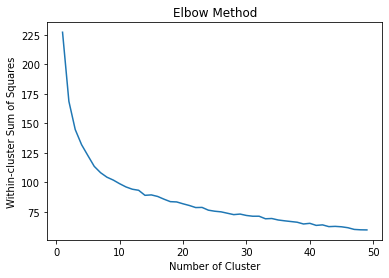

In [398]:
# Extract sum of squares for K-means clusters from 1 to 50 clusters
kmax = 50
sum_of_sq = np.zeros([kmax, 1])
for k in range(1, kmax+1):
    sum_of_sq[k-1] = KMeans(n_clusters=k).fit(ti_wideT).inertia_
    
plt.plot(range(1, kmax), sum_of_sq[1:kmax])
plt.title("Elbow Method") 
plt.xlabel("Number of Cluster") 
plt.ylabel("Within-cluster Sum of Squares")

pd.DataFrame(sum_of_sq, columns = ['Difference in SS'], index = range(1,kmax+1)).diff()

,score
2,0.765312
3,0.731949
4,0.672251
5,0.672192
6,0.200942
7,0.206344
8,0.205153
9,0.125758
10,0.135410
11,0.110407


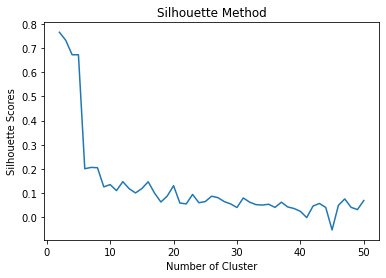

In [399]:
# Calculate Silhouette score to validate Elbow method
sil_scores = []
for k in range(2, kmax+1):
    score = KMeans(n_clusters=k, random_state=0).fit(ti_wideT).labels_
    sil_scores.append(silhouette_score(ti_wideT, score, metric='euclidean'))
    
plt.plot(range(2, kmax+1), sil_scores)
plt.title("Silhouette Method") 
plt.xlabel("Number of Cluster") 
plt.ylabel("Silhouette Scores")

pd.DataFrame(sil_scores, columns=['score'], index=range(2,kmax+1))

In [400]:
#Get 5 clusters
ti_num_clusters = 5
ti_gmm = GaussianMixture(n_components=ti_num_clusters, random_state=0)
ti_gmm.fit(ti_wideT)

#Predict for each company
ti_clusters_pred = ti_gmm.predict(ti_wideT)
ti_clusters_pred_df = pd.DataFrame({'Cluster':ti_clusters_pred,
                           'symbol':ti_wide.columns})

#Sort by Clusters
ti_clusters_pred_df = ti_clusters_pred_df.sort_values(['Cluster']).reset_index(drop=True)

#Save as csv
ti_clusters_pred_df.to_csv("ti_clusters.csv")
ti_clusters_pred_df = pd.read_csv("ti_clusters.csv", index_col=0)
ti_clusters_pred_df

,Cluster,symbol
0,0,RF
1,0,DRI
2,0,DTE
3,0,DVN
4,0,DXC
...,...,...
495,4,EPAM
496,4,ENPH
497,4,PSX
498,4,CDW


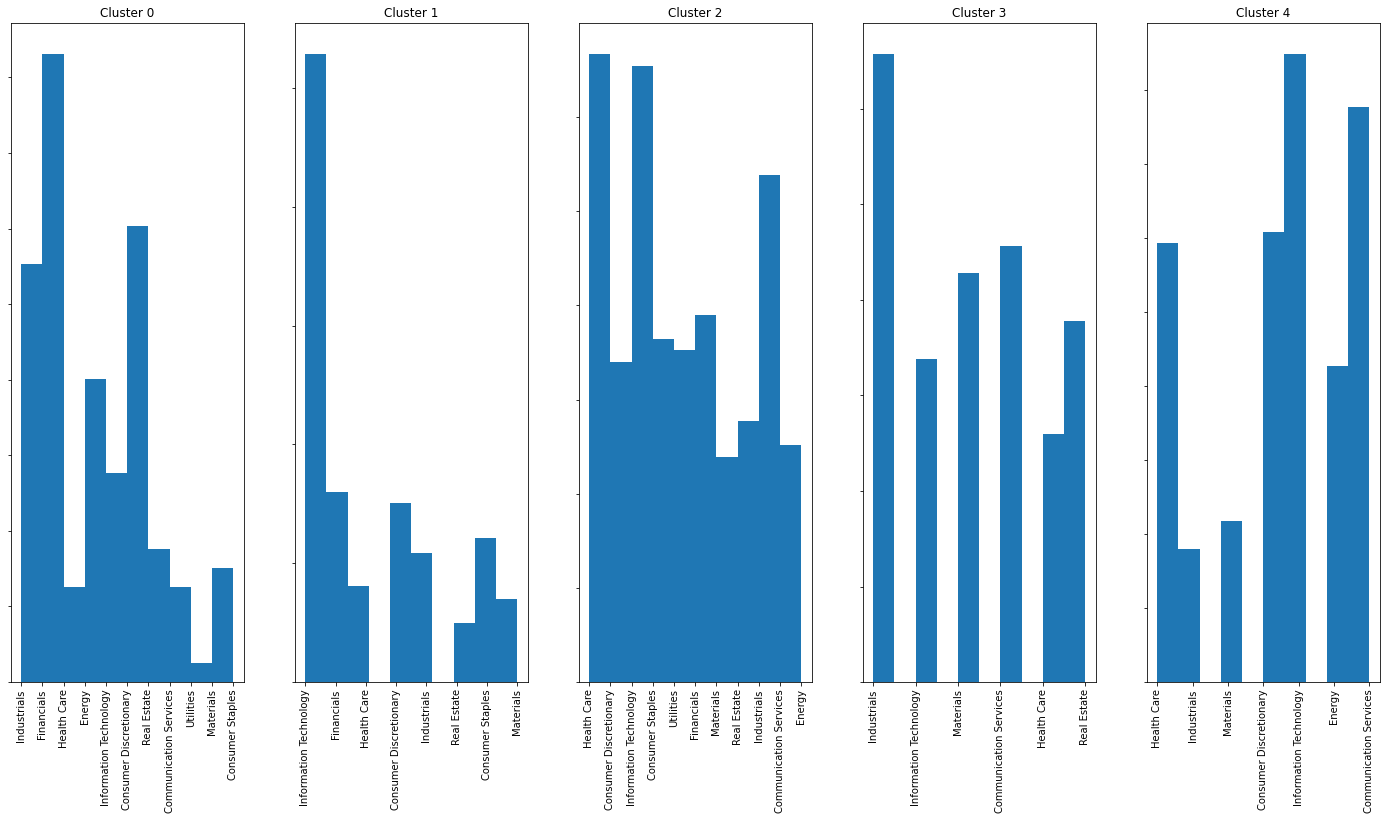

In [401]:
fig, ax = plt.subplots(1, ti_num_clusters, figsize=(20,10))
fig.tight_layout(pad=2)
for i in range(ti_num_clusters):
    cluster = ti_clusters_pred_df[ti_clusters_pred_df.Cluster==i]
    companies = cluster.symbol.unique()
    industry = data[data.symbol.isin(companies)]
    ax[i].hist(industry['industry'])
    ax[i].set_title('Cluster {}'.format(i))
    ax[i].tick_params(rotation=90, labelleft=False)

In [402]:
ind_merged = ti_clusters_pred_df.merge(data[['symbol', 'industry']].drop_duplicates(), on='symbol', how='left')
ind_merged

,Cluster,symbol,industry
0,0,RF,Financials
1,0,DRI,Consumer Discretionary
2,0,DTE,Utilities
3,0,DVN,Energy
4,0,DXC,Information Technology
...,...,...,...
495,4,EPAM,Information Technology
496,4,ENPH,Information Technology
497,4,PSX,Energy
498,4,CDW,Information Technology


In [403]:
# One-hot encode industry 
encoder = OneHotEncoder()
sparse = encoder.fit_transform(ind_merged['industry'].values.reshape(-1, 1))
ind_onehot_merged = ind_merged.merge(pd.DataFrame.sparse.from_spmatrix(sparse, columns=encoder.categories_[0]), 
                                     how='left', left_index=True, right_index=True)
ind_onehot_merged

,Cluster,symbol,industry,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,0,RF,Financials,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,DRI,Consumer Discretionary,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,DTE,Utilities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,DVN,Energy,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,DXC,Information Technology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4,EPAM,Information Technology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
496,4,ENPH,Information Technology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
497,4,PSX,Energy,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,4,CDW,Information Technology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [404]:
ind_cluster_df = ind_onehot_merged[['Cluster', 'symbol'] + list(encoder.categories_[0])].copy()
ind_cluster_df

# Pivot df such that index is symbol, columns are industries
ind_wide_list = []
for cluster in ind_cluster_df.Cluster.unique():
    ind_cluster_df_filtered = ind_cluster_df[ind_cluster_df.Cluster == cluster]
    ind_wide = ind_cluster_df_filtered.drop(['Cluster'], axis=1).set_index('symbol')
    ind_wide_list.append(ind_wide)

<ipython-input-405-48e4f6e0227c>:7: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  sum_of_sq_ind[k-1][i] = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).inertia_
<ipython-input-405-48e4f6e0227c>:7: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  sum_of_sq_ind[k-1][i] = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).inertia_
<ipython-input-405-48e4f6e0227c>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  sum_of_sq_ind[k-1][i] = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).inertia_
<ipython-input-405-48e4f6e0227c>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  sum_of_sq_ind[k-1][i] = KMeans(n_clusters=k, random_state=0).fit(in

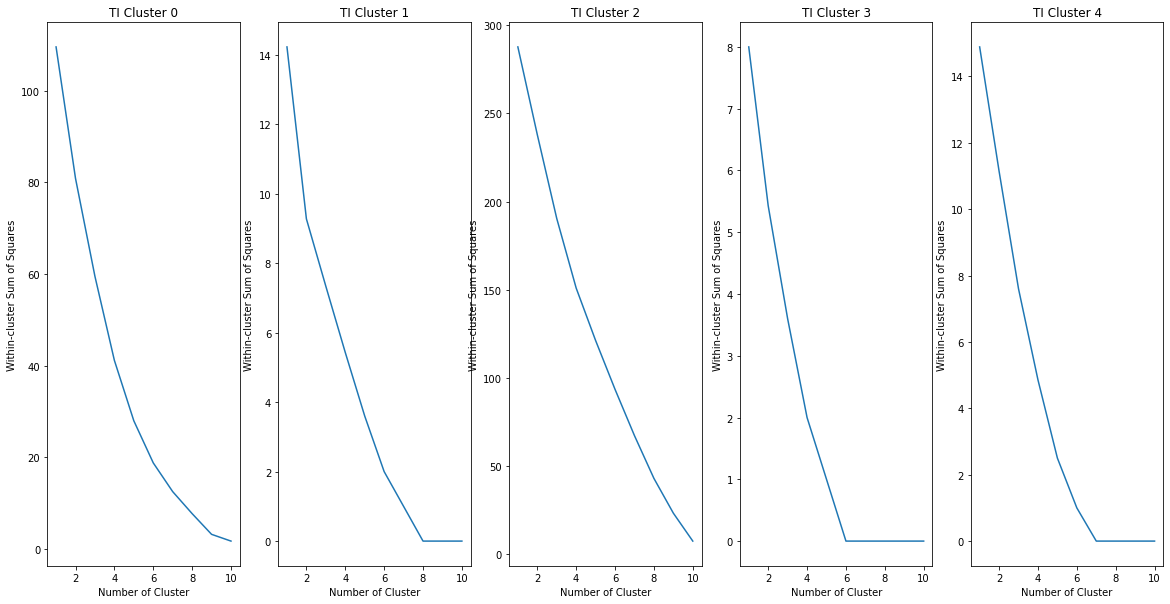

In [405]:
kmax_ind = 10
sum_of_sq_ind = np.zeros([kmax_ind, ti_num_clusters])
sum_of_sq_ind_diff = []
fig, ax = plt.subplots(1, ti_num_clusters, figsize=(20,10))
for i in range(ti_num_clusters):
    for k in range(1, kmax_ind+1):
        sum_of_sq_ind[k-1][i] = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).inertia_
    ax[i].plot(range(1, kmax_ind+1), sum_of_sq_ind[0:kmax_ind, i])
    ax[i].set_title("TI Cluster {}".format(i)) 
    ax[i].set_xlabel(xlabel="Number of Cluster")
    ax[i].set_ylabel(ylabel="Within-cluster Sum of Squares")

    sum_of_sq_ind_diff.append(pd.DataFrame(sum_of_sq_ind[0:kmax_ind, i], 
                                           columns = ['Difference in SS'], index = range(1,kmax_ind+1)).diff())

In [406]:
for i in range(len(sum_of_sq_ind_diff)):
    print('Cluster {}'.format(i))
    print(sum_of_sq_ind_diff[i])

Cluster 0
    Difference in SS
1                NaN
2         -28.713402
3         -21.407146
4         -18.342197
5         -13.194398
6          -9.192857
7          -6.279412
8          -4.803922
9          -4.523810
10         -1.476190
Cluster 1
    Difference in SS
1                NaN
2          -4.949495
3          -1.939394
4          -1.904762
5          -1.828571
6          -1.600000
7          -1.000000
8          -1.000000
9           0.000000
10          0.000000
Cluster 2
    Difference in SS
1                NaN
2         -49.740467
3         -47.506108
4         -39.476910
5         -29.729389
6         -27.696552
7         -26.244514
8         -24.223547
9         -19.715847
10        -15.833333
Cluster 3
    Difference in SS
1                NaN
2          -2.571429
3          -1.828571
4          -1.600000
5          -1.000000
6          -1.000000
7           0.000000
8           0.000000
9           0.000000
10          0.000000
Cluster 4
    Difference in SS
1    

<ipython-input-407-efb3b02d2d0c>:7: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  score = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).labels_
<ipython-input-407-efb3b02d2d0c>:7: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  score = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).labels_
<ipython-input-407-efb3b02d2d0c>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  score = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).labels_
<ipython-input-407-efb3b02d2d0c>:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  score = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).labels_
<ipython-input-407-efb3b02d2d0c>:7: Converg

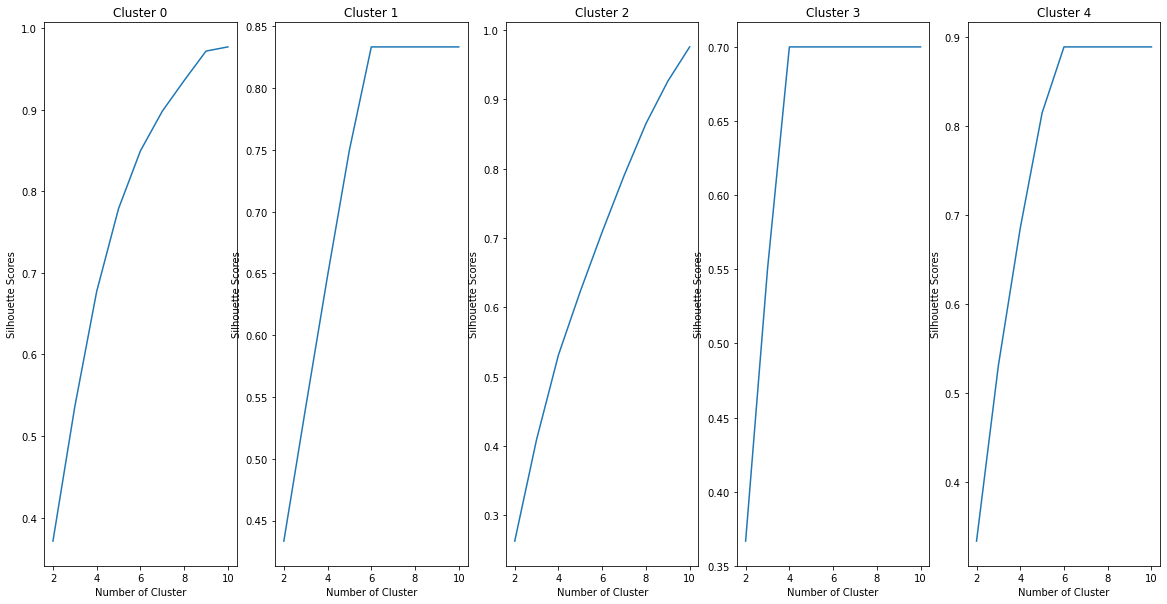

In [407]:
# Calculate Silhouette score to validate Elbow method
sil_scores_cluster = []
fig, ax = plt.subplots(1, ti_num_clusters, figsize=(20,10))
for i in range(ti_num_clusters):
    scores = []
    for k in range(2, kmax_ind+1):
        score = KMeans(n_clusters=k, random_state=0).fit(ind_wide_list[i]).labels_
        scores.append(silhouette_score(ind_wide_list[i], score, metric='euclidean'))
    sil_scores_cluster.append(score)
    
    ax[i].plot(range(2, kmax_ind+1), scores)
    ax[i].set_title("Cluster {}".format(i))
    ax[i].set_xlabel(xlabel="Number of Cluster") 
    ax[i].set_ylabel(ylabel="Silhouette Scores")

#pd.DataFrame(sil_scores, columns=['score'], index=range(2,kmax+1))

In [408]:
ind_num_clusters = [9, 6, 10, 4, 6]
ind_cluster_list = []
for i in range(len(ind_num_clusters)):
    ind_gmm = GaussianMixture(n_components=ind_num_clusters[i], random_state=0)
    ind_gmm.fit(ind_wide_list[i].sparse.to_dense())
    ind_clusters_pred = ind_gmm.predict(ind_wide_list[i].sparse.to_dense())
    ind_clusters_pred_df = pd.DataFrame({'Ind cluster': ind_clusters_pred,
                                        'symbol': ind_wide_list[i].index})
    ind_cluster_list.append(ind_clusters_pred_df)
ind_clusters_pred_df = pd.concat(ind_cluster_list, ignore_index=True)
ind_clusters_pred_df

,Ind cluster,symbol
0,0,RF
1,2,DRI
2,0,DTE
3,1,DVN
4,4,DXC
...,...,...
495,2,EPAM
496,2,ENPH
497,0,PSX
498,2,CDW


In [409]:
comb_clusters = ti_clusters_pred_df.merge(ind_clusters_pred_df, on='symbol', how='left')
comb_clusters['comb cluster'] = comb_clusters['Cluster'].astype(str) + " " + comb_clusters['Ind cluster'].astype(str)
comb_clusters.to_csv("comb_clusters.csv")
comb_clusters = pd.read_csv("comb_clusters.csv", index_col=0)
comb_clusters

,Cluster,symbol,Ind cluster,comb cluster
0,0,RF,0,0 0
1,0,DRI,2,0 2
2,0,DTE,0,0 0
3,0,DVN,1,0 1
4,0,DXC,4,0 4
...,...,...,...,...
495,4,EPAM,2,4 2
496,4,ENPH,2,4 2
497,4,PSX,0,4 0
498,4,CDW,2,4 2


In [410]:
data_clustered = data.copy()
data_clustered = data_clustered.merge(comb_clusters, on='symbol', how='left').drop(['Cluster', 'Ind cluster'], axis=1).set_index(data.index)
data_clustered

,Open,High,Low,Close,Adj Close,Volume,symbol,industry,SMA_fast,SMA_slow,...,slow_Ewm,MACD,RC,Close_Shifted,Target,Target_Direction,return,aggregate,agg_scaled,comb cluster
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03 00:00:00-05:00,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,NaN,NaN,...,29.957083,0.000000,0.086345,30.715307,2.714932,1,NaN,NaN,NaN,2 1
2011-01-04 00:00:00-05:00,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,NaN,NaN,...,29.922211,-0.058119,0.086345,30.851215,4.144447,1,-0.009356,0.549272,-0.092504,2 1
2011-01-05 00:00:00-05:00,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,NaN,NaN,...,29.883652,-0.103012,0.086345,30.736767,4.568525,1,-0.002172,0.225968,-0.093309,2 1
2011-01-06 00:00:00-05:00,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,NaN,NaN,...,29.857065,-0.112986,0.086345,30.944206,6.815986,1,0.001931,-0.220337,-0.094421,2 1
2011-01-07 00:00:00-05:00,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,29.738198,NaN,...,29.846320,-0.093233,0.086345,31.723890,2.463168,1,0.003369,-0.317328,-0.094662,2 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23 00:00:00-05:00,222.630005,224.910004,222.610001,224.240005,224.240005,4983900.0,BRK-B,Financials,223.544000,225.860669,...,224.989694,-1.219148,-0.026821,NaN,NaN,0,0.010580,1.146913,-0.091015,2 4
2020-12-24 00:00:00-05:00,224.600006,227.130005,224.210007,226.529999,226.529999,2387000.0,BRK-B,Financials,223.914001,225.561335,...,225.182232,-0.629646,-0.019436,NaN,NaN,0,0.010160,0.382184,-0.092920,2 4
2020-12-28 00:00:00-05:00,228.089996,230.149994,227.360001,228.410004,228.410004,3505500.0,BRK-B,Financials,224.910004,225.365335,...,225.585703,0.252688,-0.012708,NaN,NaN,0,0.008265,-0.058044,-0.094016,2 4


In [411]:
# Train test split
data_clustered.set_index(pd.to_datetime(data_clustered.index, utc=True).strftime('%Y-%m-%d'), inplace=True)
data_clustered

,Open,High,Low,Close,Adj Close,Volume,symbol,industry,SMA_fast,SMA_slow,...,slow_Ewm,MACD,RC,Close_Shifted,Target,Target_Direction,return,aggregate,agg_scaled,comb cluster
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,NaN,NaN,...,29.957083,0.000000,0.086345,30.715307,2.714932,1,NaN,NaN,NaN,2 1
2011-01-04,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,NaN,NaN,...,29.922211,-0.058119,0.086345,30.851215,4.144447,1,-0.009356,0.549272,-0.092504,2 1
2011-01-05,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,NaN,NaN,...,29.883652,-0.103012,0.086345,30.736767,4.568525,1,-0.002172,0.225968,-0.093309,2 1
2011-01-06,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,NaN,NaN,...,29.857065,-0.112986,0.086345,30.944206,6.815986,1,0.001931,-0.220337,-0.094421,2 1
2011-01-07,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,29.738198,NaN,...,29.846320,-0.093233,0.086345,31.723890,2.463168,1,0.003369,-0.317328,-0.094662,2 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,222.630005,224.910004,222.610001,224.240005,224.240005,4983900.0,BRK-B,Financials,223.544000,225.860669,...,224.989694,-1.219148,-0.026821,NaN,NaN,0,0.010580,1.146913,-0.091015,2 4
2020-12-24,224.600006,227.130005,224.210007,226.529999,226.529999,2387000.0,BRK-B,Financials,223.914001,225.561335,...,225.182232,-0.629646,-0.019436,NaN,NaN,0,0.010160,0.382184,-0.092920,2 4
2020-12-28,228.089996,230.149994,227.360001,228.410004,228.410004,3505500.0,BRK-B,Financials,224.910004,225.365335,...,225.585703,0.252688,-0.012708,NaN,NaN,0,0.008265,-0.058044,-0.094016,2 4


In [412]:
data_clustered_sorted = data_clustered.rename_axis('Date').sort_values(by=['symbol', 'Date'])
data_clustered_sorted

,Open,High,Low,Close,Adj Close,Volume,symbol,industry,SMA_fast,SMA_slow,...,slow_Ewm,MACD,RC,Close_Shifted,Target,Target_Direction,return,aggregate,agg_scaled,comb cluster
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,NaN,NaN,...,29.957083,0.000000,0.086345,30.715307,2.714932,1,NaN,NaN,NaN,2 1
2011-01-04,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,NaN,NaN,...,29.922211,-0.058119,0.086345,30.851215,4.144447,1,-0.009356,0.549272,-0.092504,2 1
2011-01-05,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,NaN,NaN,...,29.883652,-0.103012,0.086345,30.736767,4.568525,1,-0.002172,0.225968,-0.093309,2 1
2011-01-06,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,NaN,NaN,...,29.857065,-0.112986,0.086345,30.944206,6.815986,1,0.001931,-0.220337,-0.094421,2 1
2011-01-07,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,29.738198,NaN,...,29.846320,-0.093233,0.086345,31.723890,2.463168,1,0.003369,-0.317328,-0.094662,2 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,162.000000,162.979996,159.839996,159.850006,158.151489,1164600.0,ZTS,Health Care,161.770001,159.982667,...,160.925495,0.123597,0.005662,NaN,NaN,0,-0.012310,-0.003481,-0.093880,4 3
2020-12-24,159.919998,161.869995,159.850006,160.720001,159.012238,417400.0,ZTS,Health Care,161.374002,160.226000,...,160.899808,0.039587,0.023238,NaN,NaN,0,0.005428,0.000946,-0.093869,4 3
2020-12-28,161.440002,162.830002,160.309998,162.389999,160.664490,1522400.0,ZTS,Health Care,161.126001,160.522000,...,161.086082,0.336848,0.028110,NaN,NaN,0,0.010337,0.014552,-0.093835,4 3


In [413]:
symbol_lag_list = []
lag = 7
for ticker in data_clustered_sorted.symbol.unique():
    temp = data_clustered_sorted[data_clustered_sorted.symbol==ticker].copy()
    for regressor in indicators + ['return']:
        for i in range(1, lag):
            temp[f'{regressor}_{i}'] = temp[f'{regressor}'].shift(i)
    symbol_lag_list.append(temp)
symbol_lag_df = pd.concat(symbol_lag_list)
symbol_lag_df

,Open,High,Low,Close,Adj Close,Volume,symbol,industry,SMA_fast,SMA_slow,...,RC_3,RC_4,RC_5,RC_6,return_1,return_2,return_3,return_4,return_5,return_6
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.009356,NaN,NaN,NaN,NaN,NaN
2011-01-06,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,NaN,NaN,...,0.086345,NaN,NaN,NaN,-0.002172,-0.009356,NaN,NaN,NaN,NaN
2011-01-07,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,29.738198,NaN,...,0.086345,0.086345,NaN,NaN,0.001931,-0.002172,-0.009356,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,162.000000,162.979996,159.839996,159.850006,158.151489,1164600.0,ZTS,Health Care,161.770001,159.982667,...,0.013377,0.015669,-0.002732,-0.014482,0.006136,-0.017198,0.005700,0.012867,-0.008308,0.015306
2020-12-24,159.919998,161.869995,159.850006,160.720001,159.012238,417400.0,ZTS,Health Care,161.374002,160.226000,...,0.002868,0.013377,0.015669,-0.002732,-0.012310,0.006136,-0.017198,0.005700,0.012867,-0.008308
2020-12-28,161.440002,162.830002,160.309998,162.389999,160.664490,1522400.0,ZTS,Health Care,161.126001,160.522000,...,0.002913,0.002868,0.013377,0.015669,0.005428,-0.012310,0.006136,-0.017198,0.005700,0.012867


In [414]:
data_clustered_lagged = symbol_lag_df.copy()

In [415]:
split_date = dt.date(2016, 1, 1)
train = data_clustered_lagged[pd.to_datetime(data_clustered_lagged.index).date < split_date]
test = data_clustered_lagged[pd.to_datetime(data_clustered_lagged.index).date >= split_date]

In [487]:
# Filter out clusters with less than 180 trading days (half a year) of train data
train_filtered, test_filtered = train.copy(), test.copy()
for cluster in comb_clusters['comb cluster'].unique():
    if len(train[train['comb cluster']==cluster]) < 180:
        train_filtered = train_filtered.loc[train_filtered['comb cluster'] != cluster]
        test_filtered = test_filtered.loc[test_filtered['comb cluster'] != cluster]

In [488]:
regressors_lagged = indicators + ['return']
for regressor in indicators + ['return']:
    for i in range(1, lag):
        regressors_lagged.append(f'{regressor}_{i}')

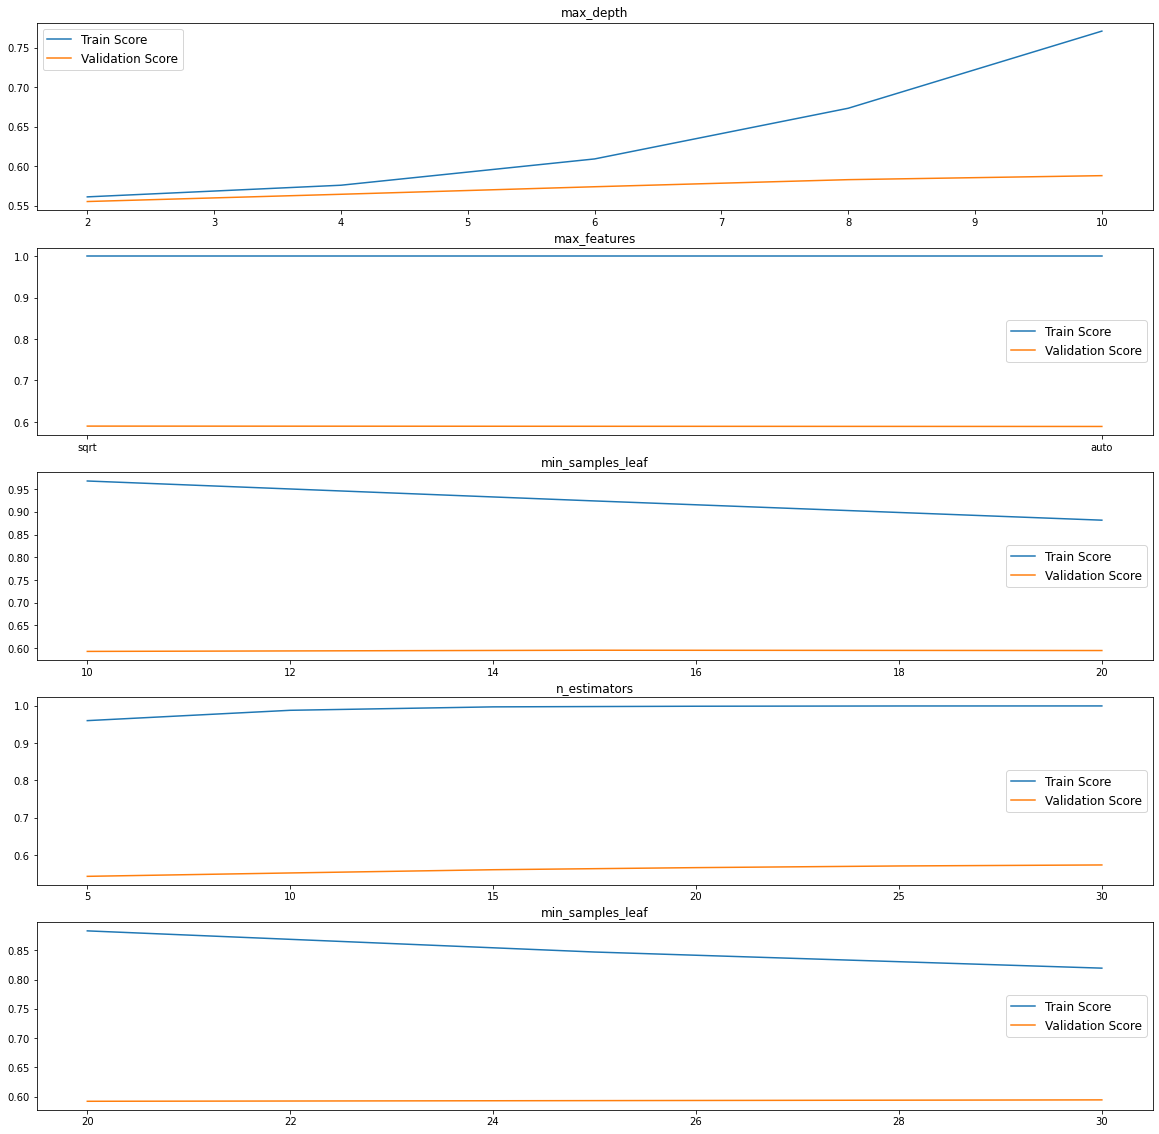

In [489]:
x_train = train_filtered.loc[:, regressors_lagged].fillna(0)
y_train = train_filtered.loc[:, ['Target_Direction']]

val_startdate = dt.date(2015, 1, 1)

param_names = ['max_depth',
              'max_features',
               'min_samples_leaf',
               'n_estimators',
               'min_samples_leaf'
              ]

param_ranges = [[i for i in range(2, 11, 2)],
                ['sqrt', 'auto'],
                [i for i in range(10, 21, 5)],
                [i for i in range(5, 31, 5)],
                [i for i in range(20, 31, 5)]]

# Create validation curve for the Random Forest Classifier
fig, ax = plt.subplots(len(param_names), 1, figsize=(20, 20))
for i in range(len(param_names)):
    rf = RandomForestClassifier()
    train_score, test_score = validation_curve(rf,
                                    X = x_train[(pd.to_datetime(train_filtered.index).date >= val_startdate) & 
                                                (pd.to_datetime(train_filtered.index).date < split_date)], 
                                    y = y_train.loc[(pd.to_datetime(train_filtered.index).date >= val_startdate) & 
                                                (pd.to_datetime(train_filtered.index).date < split_date),'Target_Direction'], 
                                    param_name = param_names[i], 
                                    param_range = param_ranges[i], cv = TimeSeriesSplit(n_splits=3))

    train_scores_mean = np.mean(train_score, axis=1)
    train_scores_std = np.std(train_score, axis=1)
    test_scores_mean = np.mean(test_score, axis=1)
    test_scores_std = np.std(test_score, axis=1)

    ax[i].plot(param_ranges[i],train_scores_mean)
    ax[i].plot(param_ranges[i],test_scores_mean)
    ax[i].legend(['Train Score','Validation Score'], fontsize = 'large')
    ax[i].set_title(param_names[i], fontsize = 'large')

In [490]:
len(train_filtered['comb cluster'].unique())

28

In [492]:
# Run the loop for every 28 unique cluster 
for cluster in train_filtered['comb cluster'].unique():
    
    print('The current cluster running is: {}'.format(cluster))
    
    # Get data for that cluster
    train_cluster = train_filtered[train_filtered.symbol.isin(train_filtered.loc[train_filtered['comb cluster']==cluster, 'symbol'].tolist())].copy()
    x_train_cluster = train_cluster.loc[:, regressors_lagged].fillna(0)
    y_train_cluster = train_cluster.loc[:, ['Target_Direction']]

    # Define parameters from Validation Curve
    params = {'max_depth': [8, 9, 10],
          'max_features': ['sqrt', 'auto'],
          'min_samples_leaf': [10, 15, 20],
          'n_estimators': [20, 25, 30],
         'min_samples_split':[5, 10, 15]} 

    rf = RandomForestClassifier()

    # Cross validation using TimeSeriesSplit
    time_series_split = TimeSeriesSplit(n_splits=3)

    
    rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(x_train_cluster, y_train_cluster)
          
    #Save the fited variable into a Pickle file
    file_loc = f'{os.getcwd()}\KMeans_GMM_RF_strategy\KMeans_GMM_RF_models\Cluster_{cluster}' 
    pickle.dump(rf_cv, open(file_loc,'wb'))

The current cluster running is: 2 1
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 3
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 0
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 2
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 4 3
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 5
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 6
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 0
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 4
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 8
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 8
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 4 5
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 4 0
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 7
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 1 2
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 3
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 1
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 4 4
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 2 9
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 4
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 2
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 5
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 4 2
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 1 0
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 1 3
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 7
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 0 6
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The current cluster running is: 4 1
Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [554]:
# Make predictions for each cluster in train data
train_preds_df_list = []
for date in train_filtered.index.unique():
    train_date = train_filtered[train_filtered.index==date].copy()
    curr_day_pred = pd.DataFrame({'Date': [],
                                 'symbol': [],
                                 'prediction': []})
    for cluster in train_date['comb cluster'].unique():
        train_date_cluster = train_date[train_date['comb cluster']==cluster].copy()
        rf_cv = pickle.load(open(f'{os.getcwd()}\KMeans_GMM_RF_strategy\KMeans_GMM_RF_models\Cluster_{cluster}', 'rb'))
        best_rf = rf_cv.best_estimator_
        x_test = train_date_cluster.loc[:, regressors_lagged].fillna(0)
        curr_day_pred = curr_day_pred.append(pd.DataFrame({'Date': train_date_cluster.index,
                                                          'symbol': train_date_cluster.symbol,
                                                          'prediction': best_rf.predict_proba(x_test)[:,1]}), 
                                             ignore_index=False)
    # Top 10 companies with highest chance to go long
    top10 = curr_day_pred.sort_values(by=['prediction'], ascending=False).head(10)
    curr_day_pred['position'] = np.where(curr_day_pred['symbol'].isin(top10['symbol']),
                                        1, 0)
    train_preds_df_list.append(curr_day_pred)
train_preds_df_list[0]

,Date,symbol,prediction,position
2011-01-03,2011-01-03,A,0.634815,0
2011-01-03,2011-01-03,ABC,0.634815,0
2011-01-03,2011-01-03,ABMD,0.634815,0
2011-01-03,2011-01-03,ABT,0.634815,0
2011-01-03,2011-01-03,AMGN,0.634815,0
...,...,...,...,...
2011-01-03,2011-01-03,EMN,0.755669,0
2011-01-03,2011-01-03,FCX,0.755669,0
2011-01-03,2011-01-03,MOS,0.755669,0
2011-01-03,2011-01-03,NUE,0.755669,0


In [555]:
train_preds_df = pd.concat(train_preds_df_list).drop(['Date'], axis=1).rename_axis('Date').sort_values(['symbol', 'Date'])
train_preds_df

,symbol,prediction,position
Date,,,
2011-01-03,A,0.634815,0
2011-01-04,A,0.674103,0
2011-01-05,A,0.680372,0
2011-01-06,A,0.707301,0
2011-01-07,A,0.657929,0
...,...,...,...
2015-12-24,ZTS,0.533706,0
2015-12-28,ZTS,0.331976,0
2015-12-29,ZTS,0.323791,0


In [556]:
train_filtered_preds = pd.concat([train_preds_df, train_filtered], axis=1).iloc[:, 1:]
train_filtered_preds 

,prediction,position,Open,High,Low,Close,Adj Close,Volume,symbol,industry,...,RC_3,RC_4,RC_5,RC_6,return_1,return_2,return_3,return_4,return_5,return_6
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,0.634815,0,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,0.674103,0,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,0.680372,0,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,...,NaN,NaN,NaN,NaN,-0.009356,NaN,NaN,NaN,NaN,NaN
2011-01-06,0.707301,0,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,...,0.086345,NaN,NaN,NaN,-0.002172,-0.009356,NaN,NaN,NaN,NaN
2011-01-07,0.657929,0,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,...,0.086345,0.086345,NaN,NaN,0.001931,-0.002172,-0.009356,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.533706,0,47.860001,48.450001,47.630001,48.130001,46.047592,965300.0,ZTS,Health Care,...,0.013704,-0.010195,-0.005110,0.003409,0.005434,0.007995,0.015755,-0.002786,-0.007674,0.002552
2015-12-28,0.331976,0,47.959999,48.200001,47.590000,47.900002,45.827538,928300.0,ZTS,Health Care,...,0.015103,0.013704,-0.010195,-0.005110,0.003121,0.005434,0.007995,0.015755,-0.002786,-0.007674
2015-12-29,0.323791,0,48.369999,48.619999,47.959999,48.330002,46.238937,1483800.0,ZTS,Health Care,...,0.034721,0.015103,0.013704,-0.010195,-0.004790,0.003121,0.005434,0.007995,0.015755,-0.002786


In [557]:
# Get P&L of strategy
train_cum_strategies_list = []
for ticker in train_filtered_preds.symbol.unique():
    ticker_strat = train_filtered_preds[train_filtered_preds.symbol==ticker].copy()
    ticker_strat['log_target'] = np.log((ticker_strat.Close_Shifted/ticker_strat.Open).shift(-1))
    ticker_strat['strategy'] = ticker_strat['log_target'].shift(7)*ticker_strat['position'].shift(7)
    ticker_strat['cumstrategy'] = ticker_strat['strategy'].cumsum().apply(np.exp)
    train_cum_strategies_list.append(ticker_strat[['symbol', 'strategy', 'cumstrategy', 'log_target']])
train_cum_strategies = pd.concat(train_cum_strategies_list)
train_cum_strategies

,symbol,strategy,cumstrategy,log_target
Date,,,,
2011-01-03,A,NaN,NaN,0.026787
2011-01-04,A,NaN,NaN,0.040609
2011-01-05,A,NaN,NaN,0.044672
2011-01-06,A,NaN,NaN,0.065937
2011-01-07,A,NaN,NaN,0.024333
...,...,...,...,...
2015-12-24,ZTS,0.014862,4.373104,0.001250
2015-12-28,ZTS,0.013240,4.431388,-0.038138
2015-12-29,ZTS,0.036452,4.595901,-0.052023


In [558]:
train_strategies = train_filtered_preds.copy()
train_strategies[['strategy', 'cumstrategy', 'log_target']] = train_cum_strategies[['strategy', 'cumstrategy', 'log_target']]
train_strategies

,prediction,position,Open,High,Low,Close,Adj Close,Volume,symbol,industry,...,RC_6,return_1,return_2,return_3,return_4,return_5,return_6,strategy,cumstrategy,log_target
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,0.634815,0,29.728184,30.143063,29.620888,29.957083,27.204119,4994075.0,A,Health Care,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026787
2011-01-04,0.674103,0,30.035765,30.114449,29.456366,29.678112,26.950785,5017282.0,A,Health Care,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040609
2011-01-05,0.680372,0,29.513592,29.849785,29.327612,29.613733,26.892321,4519035.0,A,Health Care,...,NaN,-0.009356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044672
2011-01-06,0.707301,0,29.592276,29.928469,29.477825,29.670959,26.944290,4699097.0,A,Health Care,...,NaN,-0.002172,-0.009356,NaN,NaN,NaN,NaN,NaN,NaN,0.065937
2011-01-07,0.657929,0,29.699572,29.899857,29.356222,29.771103,27.035229,3810948.0,A,Health Care,...,NaN,0.001931,-0.002172,-0.009356,NaN,NaN,NaN,NaN,NaN,0.024333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.533706,0,47.860001,48.450001,47.630001,48.130001,46.047592,965300.0,ZTS,Health Care,...,0.003409,0.005434,0.007995,0.015755,-0.002786,-0.007674,0.002552,0.014862,4.373104,0.001250
2015-12-28,0.331976,0,47.959999,48.200001,47.590000,47.900002,45.827538,928300.0,ZTS,Health Care,...,-0.005110,0.003121,0.005434,0.007995,0.015755,-0.002786,-0.007674,0.013240,4.431388,-0.038138
2015-12-29,0.323791,0,48.369999,48.619999,47.959999,48.330002,46.238937,1483800.0,ZTS,Health Care,...,-0.010195,-0.004790,0.003121,0.005434,0.007995,0.015755,-0.002786,0.036452,4.595901,-0.052023


In [559]:
train_ticker_strategies = train_strategies[train_strategies.index==train_strategies.index[-1]]
train_top10_ticker = train_ticker_strategies.sort_values(by=['cumstrategy'], ascending=False).head(10)
train_top10_ticker[['symbol', 'cumstrategy']]

,symbol,cumstrategy
Date,,
2015-12-31,FANG,38859.814977
2015-12-31,PSX,21353.317669
2015-12-31,ENPH,4165.852126
2015-12-31,CZR,1385.545449
2015-12-31,LYV,371.562385
2015-12-31,EPAM,347.731166
2015-12-31,APTV,283.573931
2015-12-31,DISH,250.637635
2015-12-31,NOW,236.330793


In [560]:
train_bot10_ticker = train_ticker_strategies.sort_values(by=['cumstrategy']).head(10)
train_bot10_ticker[['symbol', 'cumstrategy']]

,symbol,cumstrategy
Date,,
2015-12-31,A,0.370634
2015-12-31,DGX,0.534868
2015-12-31,TSCO,0.629961
2015-12-31,HD,0.720371
2015-12-31,AMGN,0.724433
2015-12-31,ELV,0.813047
2015-12-31,BIO,0.835873
2015-12-31,LH,0.861866
2015-12-31,ABC,0.863140


In [575]:
train_hits = np.where((train_strategies['Target_Direction'] == train_strategies['position']) & 
                      (train_strategies['position'] == 1), 1, 0)
np.sum(train_hits)/np.sum(train_strategies.position)*100

92.09856915739269

In [562]:
train_daily_strategies = train_strategies.groupby(train_strategies.index).mean()[['cumstrategy']]
train_daily_strategies

,cumstrategy
Date,
2011-01-03,NaN
2011-01-04,NaN
2011-01-05,NaN
2011-01-06,NaN
2011-01-07,NaN
...,...
2015-12-24,136.089945
2015-12-28,136.104671
2015-12-29,136.113034


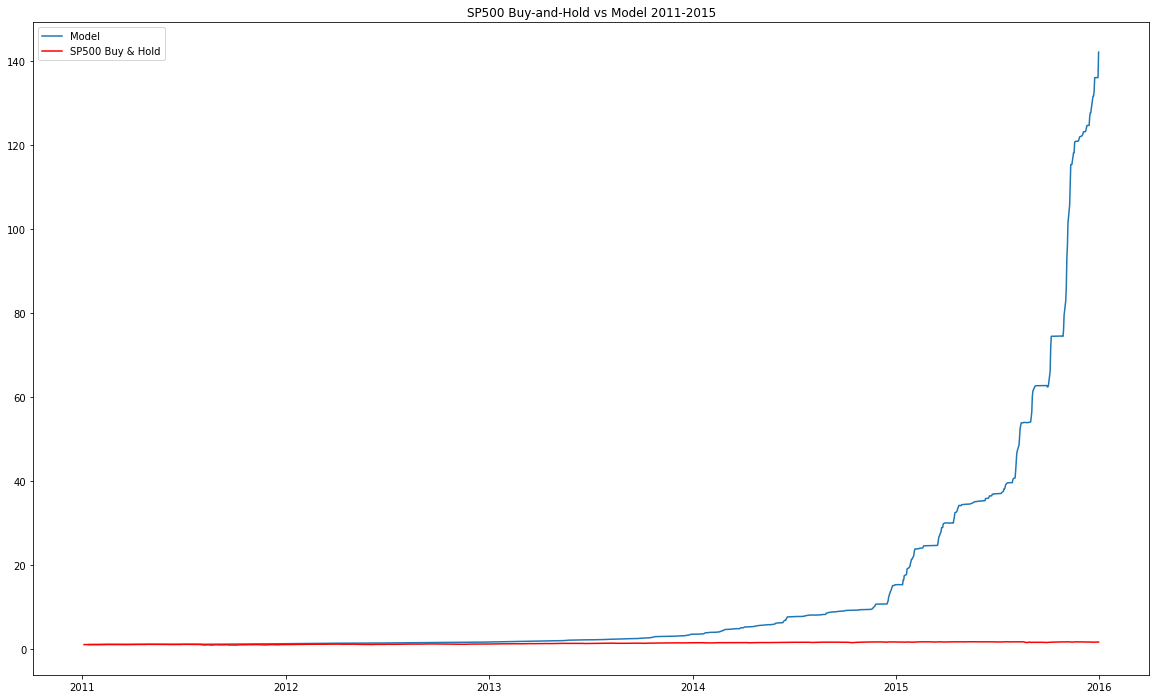

In [563]:
plt.figure(figsize=(20, 12))
plt.plot(pd.to_datetime(train_daily_strategies.index).date, train_daily_strategies.cumstrategy, label='Model')
plt.plot(sp500_train.index, sp500_train['cumreturn'], color='red', label='SP500 Buy & Hold')
plt.title('SP500 Buy-and-Hold vs Model 2011-2015')
plt.legend()

In [564]:
# Make predictions for each cluster in test data
preds_df_list = []
for date in test_filtered.index.unique():
    test_date = test_filtered[test_filtered.index==date].copy()
    curr_day_pred = pd.DataFrame({'Date': [],
                                 'symbol': [],
                                 'prediction': []})
    for cluster in test_date['comb cluster'].unique():
        test_date_cluster = test_date[test_date['comb cluster']==cluster].copy()
        rf_cv = pickle.load(open(f'{os.getcwd()}\KMeans_GMM_RF_strategy\KMeans_GMM_RF_models\Cluster_{cluster}', 'rb'))
        best_rf = rf_cv.best_estimator_
        x_test = test_date_cluster.loc[:, regressors_lagged].fillna(0)
        curr_day_pred = curr_day_pred.append(pd.DataFrame({'Date': test_date_cluster.index,
                                                          'symbol': test_date_cluster.symbol,
                                                          'prediction': best_rf.predict_proba(x_test)[:,1]}), 
                                             ignore_index=False)
    # Top 10 companies with highest chance to go long
    top10 = curr_day_pred.sort_values(by=['prediction'], ascending=False).head(10)
    curr_day_pred['position'] = np.where(curr_day_pred['symbol'].isin(top10['symbol']),
                                        1, 0)
    preds_df_list.append(curr_day_pred)
preds_df_list[0]

,Date,symbol,prediction,position
2016-01-04,2016-01-04,A,0.562600,0
2016-01-04,2016-01-04,ABC,0.623870,0
2016-01-04,2016-01-04,ABMD,0.446140,0
2016-01-04,2016-01-04,ABT,0.557023,0
2016-01-04,2016-01-04,AMGN,0.545450,0
...,...,...,...,...
2016-01-04,2016-01-04,PPG,0.462551,0
2016-01-04,2016-01-04,META,0.432837,0
2016-01-04,2016-01-04,NWS,0.375197,0
2016-01-04,2016-01-04,NWSA,0.500631,0


In [565]:
preds_df = pd.concat(preds_df_list).drop(['Date'], axis=1).rename_axis('Date').sort_values(['symbol', 'Date'])
preds_df

,symbol,prediction,position
Date,,,
2016-01-04,A,0.562600,0
2016-01-05,A,0.540928,0
2016-01-06,A,0.578744,0
2016-01-07,A,0.536353,0
2016-01-08,A,0.597083,0
...,...,...,...
2020-12-23,ZTS,0.507514,0
2020-12-24,ZTS,0.490028,0
2020-12-28,ZTS,0.529500,0


In [566]:
test_filtered_preds = pd.concat([preds_df, test_filtered], axis=1).iloc[:, 1:]
test_filtered_preds 

,prediction,position,Open,High,Low,Close,Adj Close,Volume,symbol,industry,...,RC_3,RC_4,RC_5,RC_6,return_1,return_2,return_3,return_4,return_5,return_6
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.562600,0,41.060001,41.189999,40.340000,40.689999,38.468811,3287300.0,A,Health Care,...,0.040786,0.016545,0.049564,0.033399,-0.008573,-0.004496,0.013787,-0.008580,0.008819,0.013255
2016-01-05,0.540928,0,40.730000,40.950001,40.340000,40.549999,38.336441,2587200.0,A,Health Care,...,0.024290,0.040786,0.016545,0.049564,-0.027153,-0.008573,-0.004496,0.013787,-0.008580,0.008819
2016-01-06,0.578744,0,40.240002,40.990002,40.049999,40.730000,38.506626,2103600.0,A,Health Care,...,0.020254,0.024290,0.040786,0.016545,-0.003447,-0.027153,-0.008573,-0.004496,0.013787,-0.008580
2016-01-07,0.536353,0,40.139999,40.150002,38.810001,39.000000,36.871052,3504300.0,A,Health Care,...,-0.013576,0.020254,0.024290,0.040786,0.004429,-0.003447,-0.027153,-0.008573,-0.004496,0.013787
2016-01-08,0.597083,0,39.220001,39.709999,38.470001,38.590000,36.483437,3736700.0,A,Health Care,...,0.008957,-0.013576,0.020254,0.024290,-0.043403,0.004429,-0.003447,-0.027153,-0.008573,-0.004496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.507514,0,162.000000,162.979996,159.839996,159.850006,158.151489,1164600.0,ZTS,Health Care,...,0.013377,0.015669,-0.002732,-0.014482,0.006136,-0.017198,0.005700,0.012867,-0.008308,0.015306
2020-12-24,0.490028,0,159.919998,161.869995,159.850006,160.720001,159.012238,417400.0,ZTS,Health Care,...,0.002868,0.013377,0.015669,-0.002732,-0.012310,0.006136,-0.017198,0.005700,0.012867,-0.008308
2020-12-28,0.529500,0,161.440002,162.830002,160.309998,162.389999,160.664490,1522400.0,ZTS,Health Care,...,0.002913,0.002868,0.013377,0.015669,0.005428,-0.012310,0.006136,-0.017198,0.005700,0.012867


In [567]:
# Get P&L of strategy
cum_strategies_list = []
for ticker in test_filtered_preds.symbol.unique():
    ticker_strat = test_filtered_preds[test_filtered_preds.symbol==ticker].copy()
    ticker_strat['log_target'] = np.log((ticker_strat.Close_Shifted/ticker_strat.Open).shift(-1))
    ticker_strat['strategy'] = ticker_strat['log_target'].shift(7)*ticker_strat['position'].shift(7)
    ticker_strat['cumstrategy'] = ticker_strat['strategy'].cumsum().apply(np.exp)
    cum_strategies_list.append(ticker_strat[['symbol', 'strategy', 'cumstrategy', 'log_target']])
cum_strategies = pd.concat(cum_strategies_list)
cum_strategies

,symbol,strategy,cumstrategy,log_target
Date,,,,
2016-01-04,A,NaN,NaN,-0.099838
2016-01-05,A,NaN,NaN,-0.067592
2016-01-06,A,NaN,NaN,-0.078487
2016-01-07,A,NaN,NaN,-0.052878
2016-01-08,A,NaN,NaN,-0.038178
...,...,...,...,...
2020-12-23,ZTS,-0.000000,0.995436,NaN
2020-12-24,ZTS,-0.010152,0.985381,NaN
2020-12-28,ZTS,0.003084,0.988424,NaN


In [568]:
test_strategies = test_filtered_preds.copy()
test_strategies[['strategy', 'cumstrategy', 'log_target']] = cum_strategies[['strategy', 'cumstrategy', 'log_target']]
test_strategies

,prediction,position,Open,High,Low,Close,Adj Close,Volume,symbol,industry,...,RC_6,return_1,return_2,return_3,return_4,return_5,return_6,strategy,cumstrategy,log_target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.562600,0,41.060001,41.189999,40.340000,40.689999,38.468811,3287300.0,A,Health Care,...,0.033399,-0.008573,-0.004496,0.013787,-0.008580,0.008819,0.013255,NaN,NaN,-0.099838
2016-01-05,0.540928,0,40.730000,40.950001,40.340000,40.549999,38.336441,2587200.0,A,Health Care,...,0.049564,-0.027153,-0.008573,-0.004496,0.013787,-0.008580,0.008819,NaN,NaN,-0.067592
2016-01-06,0.578744,0,40.240002,40.990002,40.049999,40.730000,38.506626,2103600.0,A,Health Care,...,0.016545,-0.003447,-0.027153,-0.008573,-0.004496,0.013787,-0.008580,NaN,NaN,-0.078487
2016-01-07,0.536353,0,40.139999,40.150002,38.810001,39.000000,36.871052,3504300.0,A,Health Care,...,0.040786,0.004429,-0.003447,-0.027153,-0.008573,-0.004496,0.013787,NaN,NaN,-0.052878
2016-01-08,0.597083,0,39.220001,39.709999,38.470001,38.590000,36.483437,3736700.0,A,Health Care,...,0.024290,-0.043403,0.004429,-0.003447,-0.027153,-0.008573,-0.004496,NaN,NaN,-0.038178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.507514,0,162.000000,162.979996,159.839996,159.850006,158.151489,1164600.0,ZTS,Health Care,...,-0.014482,0.006136,-0.017198,0.005700,0.012867,-0.008308,0.015306,-0.000000,0.995436,NaN
2020-12-24,0.490028,0,159.919998,161.869995,159.850006,160.720001,159.012238,417400.0,ZTS,Health Care,...,-0.002732,-0.012310,0.006136,-0.017198,0.005700,0.012867,-0.008308,-0.010152,0.985381,NaN
2020-12-28,0.529500,0,161.440002,162.830002,160.309998,162.389999,160.664490,1522400.0,ZTS,Health Care,...,0.015669,0.005428,-0.012310,0.006136,-0.017198,0.005700,0.012867,0.003084,0.988424,NaN


In [569]:
ticker_strategies = test_strategies[test_strategies.index==test_strategies.index[-1]]
top10_ticker = ticker_strategies.sort_values(by=['cumstrategy'], ascending=False).head(10)
top10_ticker[['symbol', 'cumstrategy']]

,symbol,cumstrategy
Date,,
2020-12-30,ENPH,9.755814
2020-12-30,ZBH,5.179179
2020-12-30,ESS,4.326133
2020-12-30,MOS,4.165995
2020-12-30,C,4.037800
2020-12-30,CDW,3.972105
2020-12-30,ANET,3.495102
2020-12-30,MTCH,3.427085
2020-12-30,NOW,3.424120


In [570]:
ticker_strategies = test_strategies[test_strategies.index==test_strategies.index[-1]]
bot10_ticker = ticker_strategies.sort_values(by=['cumstrategy']).head(10)
bot10_ticker[['symbol', 'cumstrategy']]

,symbol,cumstrategy
Date,,
2020-12-30,NCLH,0.000276
2020-12-30,PCG,0.170572
2020-12-30,FANG,0.175184
2020-12-30,ALLE,0.226127
2020-12-30,BA,0.237058
2020-12-30,ALGN,0.242206
2020-12-30,EQT,0.363589
2020-12-30,ABBV,0.380765
2020-12-30,CZR,0.452660


In [576]:
hits = np.where((test_strategies['Target_Direction'] == test_strategies['position']) & 
                (test_strategies['position'] == 1), 1, 0)
np.sum(hits)/np.sum(test_strategies.position)*100

55.17077045274027

In [572]:
daily_strategies = test_strategies.groupby(test_strategies.index).mean()[['cumstrategy']]
daily_strategies

,cumstrategy
Date,
2016-01-04,NaN
2016-01-05,NaN
2016-01-06,NaN
2016-01-07,NaN
2016-01-08,NaN
...,...
2020-12-24,1.195057
2020-12-28,1.195296
2020-12-29,1.195175


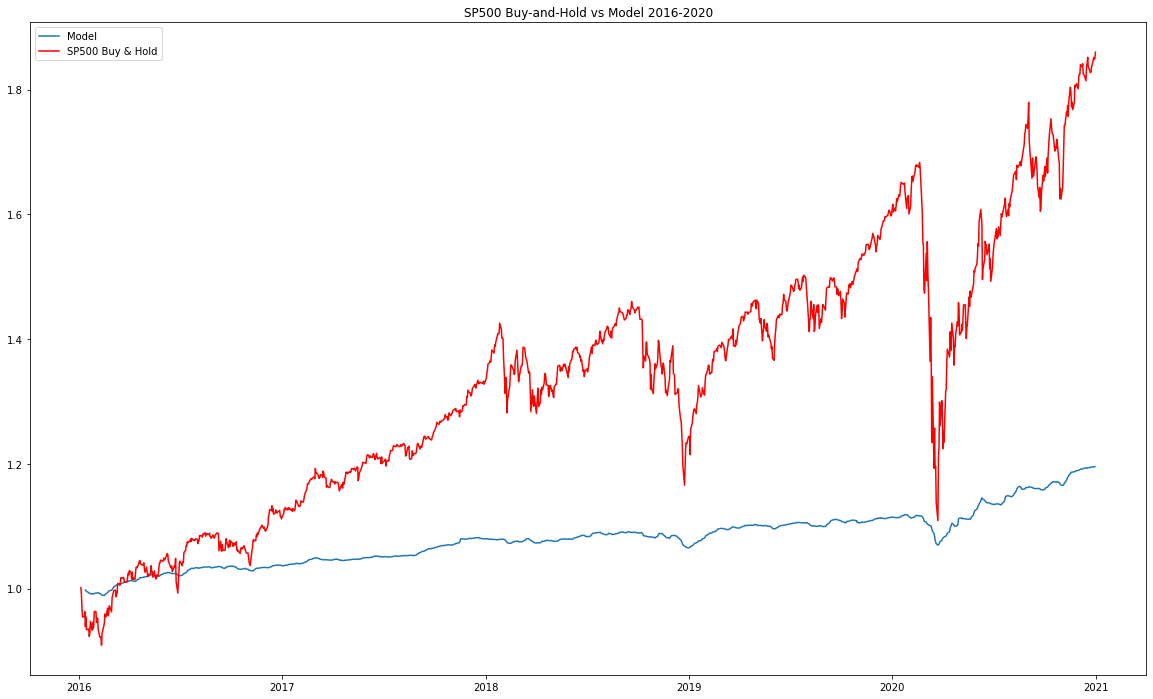

In [573]:
plt.figure(figsize=(20, 12))
plt.plot(pd.to_datetime(daily_strategies.index).date, daily_strategies.cumstrategy, label='Model')
plt.plot(sp500_test.index, sp500_test['cumreturn'], color='red', label='SP500 Buy & Hold')
plt.title('SP500 Buy-and-Hold vs Model 2016-2020')
plt.legend()